# Model Improvement After Feedback (10/09)

We show the desired outcome (**L1** and **L2** products on the full time series) with the continuous integration setup.  

To reduce the willingness of the data, we add a local filter which consider as outlier an observation based on the local delta distribution.

We will only consider the **forecasted data**, since the retroactive gapfilled data are identical.  

---

## Improvements

The improvements are the following:  

- adding a local filter to reduce the data willingness
- Including a multiplicative factor to avoid unwanted behavior  
- Testing the three different smoothing options


In [1]:
from IPython.display import IFrame, Image, display
import numpy as np
import math
import zarr
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import xarray as xr
import torch
import torch.nn as nn
import pandas as pd
from scipy.signal import savgol_filter
import gc
import imageio
from io import BytesIO
from rasterio import features
from affine import Affine
from functions import *

This is the full gapfilled time serie with the smoothing using Savitzky Golay

/home/francesco/miniconda3/envs/ndvi/lib/python3.11/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/home/francesco/data_scratch/swiss-ndvi-processing/demo/notebook/functions.py:114: RuntimeWarning: divide by zero encountered in divide
  iqr_param = np.where(valid_ndvi / median_valid < 1, median_valid / valid_ndvi, valid_ndvi / median_valid)
/home/francesco/data_scratch/swiss-ndvi-processing/demo/notebook/functions.py:209: RuntimeWarning: divide by zero encountered in divide
  ratio = np.maximum(valid_ndvi, median_valid) / np.minimum(valid_ndvi, median_valid)


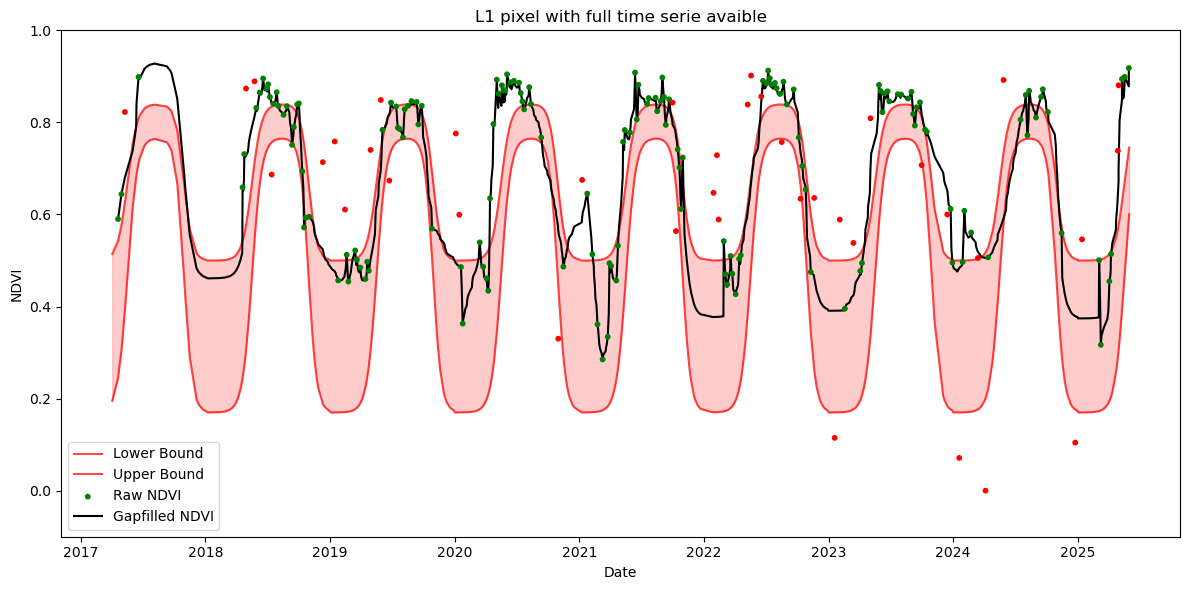

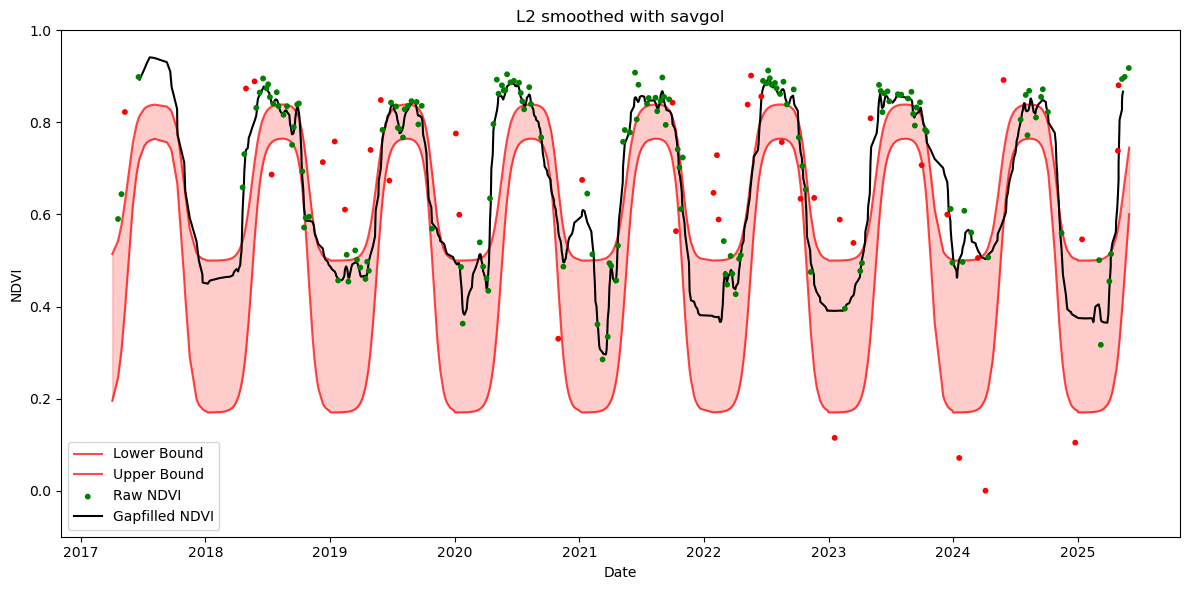

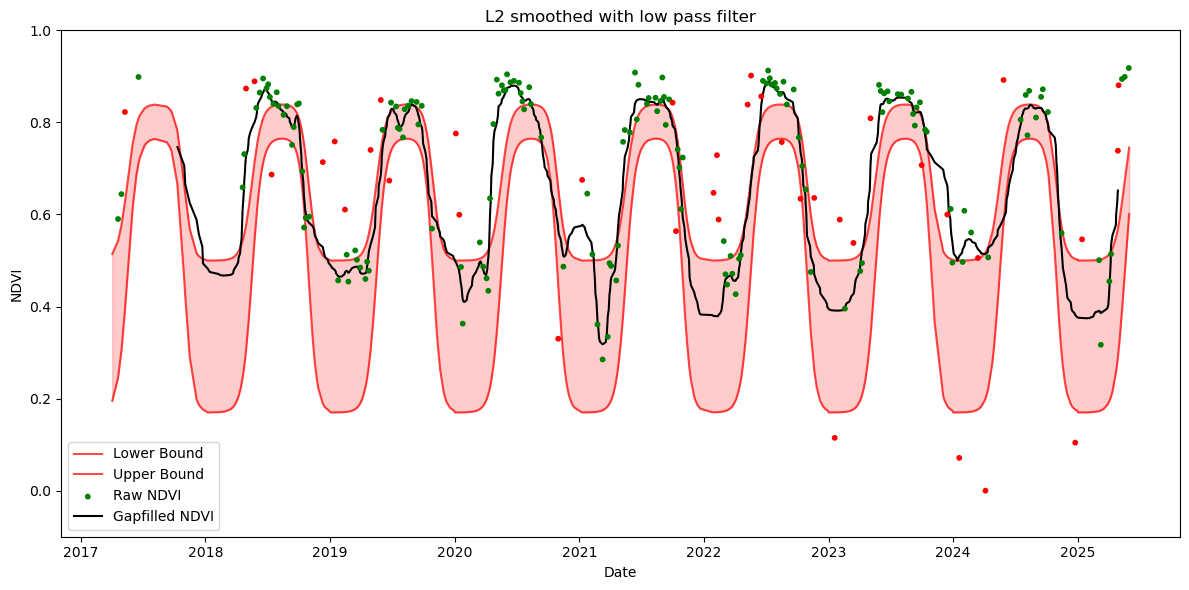

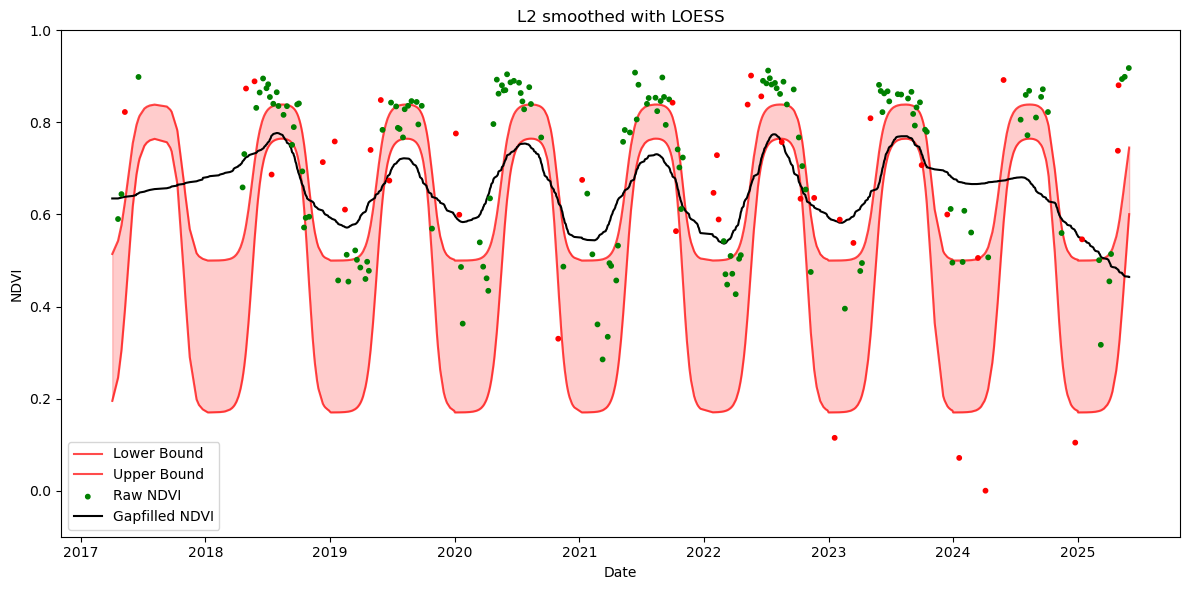

In [2]:
# data loading and raster initialization
# ----- Config -----
zarr_path = "../pixel_biomes.zarr/ndvi"

z = zarr.open(zarr_path, mode="r")

# fitting and smoothing
# ----- seasonal cycle fitting -----
ds = xr.open_zarr("../../sample_seasonal_cycle_parameter_preds.zarr")
ndvi = ds["ndvi"]
dates = ds["dates"]
params_lower = torch.tensor(ds["params_lower"].values)
params_upper = torch.tensor(ds["params_upper"].values)

# convert dates to doy
dates_pd = pd.to_datetime(dates)
df = pd.DataFrame({"date": dates_pd})
df_sorted = df.sort_values(by="date")
dates_sorted = df_sorted["date"].values
dates_pd_sorted = pd.to_datetime(dates_sorted)
doy = dates_pd_sorted.dayofyear.values
doy = torch.tensor(doy, dtype=torch.float32)
T_SCALE = 1.0 / 365.0
t = doy.unsqueeze(0).repeat(params_lower.shape[0], 1) * T_SCALE


lower = double_logistic_function(t[[0]], params_lower[[91]]).squeeze().cpu().numpy()
upper = double_logistic_function(t[[0]], params_upper[[91]]).squeeze().cpu().numpy()

median_iqr = upper - (upper - lower) / 2

param_iqr = 1.02
bottom_iqr = 0.2
upper_iqr = 0.8
window_length = 14
polyorder = 2

random_pixels = 120  # pick one pixel index to check

ndvi_series = z[random_pixels, :]

# proper sorting

df = pd.DataFrame({
    'date': dates_pd,
    'ndvi': ndvi_series
    })

df_sorted = df.sort_values(by='date')

ndvi_sorted = df_sorted['ndvi'].values

ndvi_gapfilled, outlier_arr, q_hi, q_low, delta_diff, iqr_param, smoothed = gapfill_ndvi(ndvi_sorted, lower, upper,forecasting=False,
                                            param_iqr=1.02,bottom_q=0.4,
                                            top_q=0.6,return_quantiles = True, weight_median = 0.5,smoothing_method = "savgol")

#smoothed_data = savgol_filter(ndvi_gapfilled, window_length=window_length, polyorder=polyorder) 


plot_results(
        title= "L1 pixel with full time serie avaible",
        ndvi_series=ndvi_sorted / 10000.0,
        ndvi_gapfilled=ndvi_gapfilled,
        outlier_arr=outlier_arr,
        lower=lower,
        upper=upper,
        dates=dates_sorted
    )

plot_results(
        title= "L2 smoothed with savgol",
        ndvi_series=ndvi_sorted / 10000.0, 
        ndvi_gapfilled=smoothed,
        outlier_arr=outlier_arr,
        lower=lower,
        upper=upper,
        dates=dates_sorted
    )

ndvi_gapfilled, outlier_arr, q_hi, q_low, delta_diff, iqr_param, smoothed = gapfill_ndvi(ndvi_sorted, lower, upper,forecasting=False,
                                            param_iqr=1.02,bottom_q=0.4,
                                            top_q=0.6,return_quantiles = True, weight_median = 0.5,smoothing_method = "low_pass")


plot_results(
        title= "L2 smoothed with low pass filter",
        ndvi_series=ndvi_sorted / 10000.0, 
        ndvi_gapfilled=smoothed,
        outlier_arr=outlier_arr,
        lower=lower,
        upper=upper,
        dates=dates_sorted
    )

ndvi_gapfilled, outlier_arr, q_hi, q_low, delta_diff, iqr_param, smoothed = gapfill_ndvi(ndvi_sorted, lower, upper,forecasting=False,
                                            param_iqr=1.02,bottom_q=0.4,
                                            top_q=0.6,return_quantiles = True, weight_median = 0.5,smoothing_method = "loess", frac = 0.15)


plot_results(
        title= "L2 smoothed with LOESS",
        ndvi_series=ndvi_sorted / 10000.0, 
        ndvi_gapfilled=smoothed,
        outlier_arr=outlier_arr,
        lower=lower,
        upper=upper,
        dates=dates_sorted
    )





Here we mimick the minimum amount of data necessary to mimick the outlier detection not haveing access to the ful time series

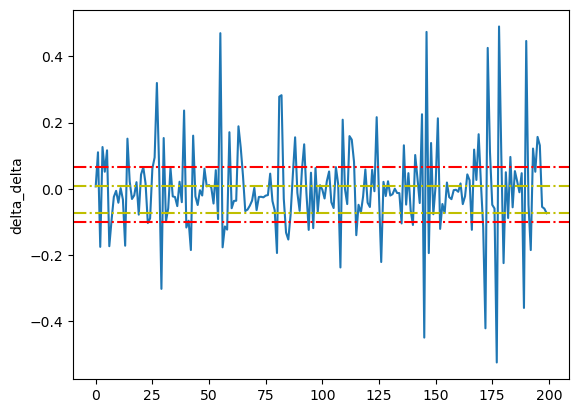

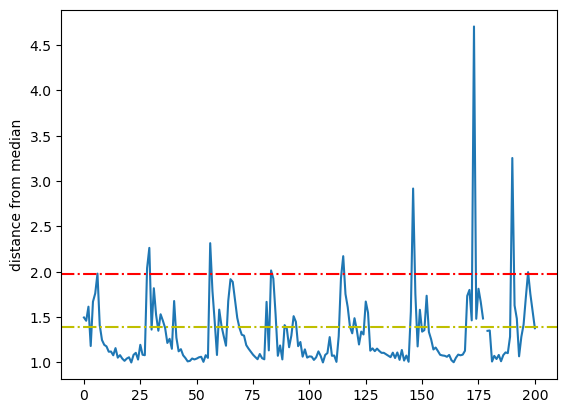

In [3]:
y_delta_l , y_delta_h,r_delta_h, r_delta_l  = np.quantile(delta_diff, [0.2,0.6,0.8,0.15])
y_iqr, r_iqr = np.quantile(iqr_param, [0.7, 0.95])

plt.plot(np.arange(0,len(delta_diff)),delta_diff)
plt.axhline(y=y_delta_l, color='y', linestyle='-.')
plt.axhline(y=y_delta_h, color='y', linestyle='-.')
plt.axhline(y=r_delta_l, color='r', linestyle='-.')
plt.axhline(y=r_delta_h, color='r', linestyle='-.')
plt.ylabel("delta_delta")  
plt.show()

plt.plot(np.arange(0,len(iqr_param)),iqr_param)
plt.axhline(y=y_iqr, color='y', linestyle='-.')
plt.axhline(y=r_iqr, color='r', linestyle='-.')
plt.ylabel("distance from median")  
plt.show()

This is the continous integration as shown in the previous notebook

/home/francesco/data_scratch/swiss-ndvi-processing/demo/notebook/functions.py:325: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = np.maximum(obs, median_curr) / np.minimum(obs, median_curr)


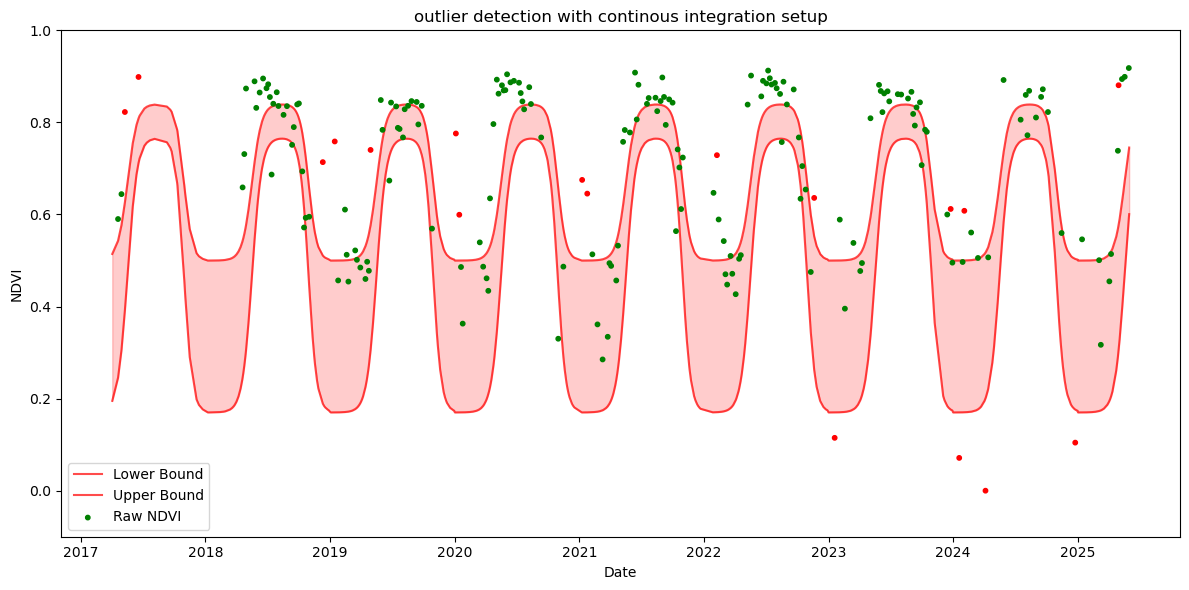

In [4]:
ndvi_filled, outlier_arr, forecast_only, smoothed = gapfill_ndvi(ndvi_sorted, lower, upper,forecasting=True,
                                                                param_iqr=1.5,
                                                                bottom_q=0.3,
                                                                top_q=0.7,
                                                                weight_median = 0.5,
                                                                y_delta_l = y_delta_l, 
                                                                y_delta_h =y_delta_h,
                                                                r_delta_h =r_delta_h, 
                                                                r_delta_l =r_delta_l, 
                                                                y_iqr = y_iqr,
                                                                r_iqr = r_iqr,
                                                                window_smoothing = 14,
                                                                use_tau= True,
                                                                tau = 7,
                                                                lag_forecast= 14)


colors = np.where(outlier_arr, "red", "green")

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(dates_sorted, lower, label="Lower Bound", color="red", alpha=0.7)
ax.plot(dates_sorted, upper, label="Upper Bound", color="red", alpha=0.7)
ax.fill_between(dates_sorted, lower, upper, alpha=0.2, color="red")

ax.scatter(dates_sorted, ndvi_sorted / 10000.0, s=10, color=colors, label="Raw NDVI", zorder=3)


ax.set_title("outlier detection with continous integration setup")
ax.set_ylim(-0.1, 1.0)
ax.set_xlabel("Date")
ax.set_ylabel("NDVI")
ax.legend()
plt.tight_layout()


Increasing the smoothing window or the lag between the ingested data and the smoothing does not improve the smoothing performance.  
Therefore, it is necessary to adopt a realistic representation of the continuous L1 product.  

We propose an exponential decay factor that depends on the lag days (the time difference between the current day and the last known true value).  

The factor starts at **1** when the lag is minimal and decreases toward **0** as the lag increases, following the formula:  

$$
f = e^{-\ln(2) \cdot ( \text{lag\_days} / \tau )}
$$

The factor has one parameter **$\tau$**, indicating the lag at which the factor has a value of 0.5.

This factor is then multiplied by the last known delta, allowing the data to gradually converge toward the center of the band as the lag increases.


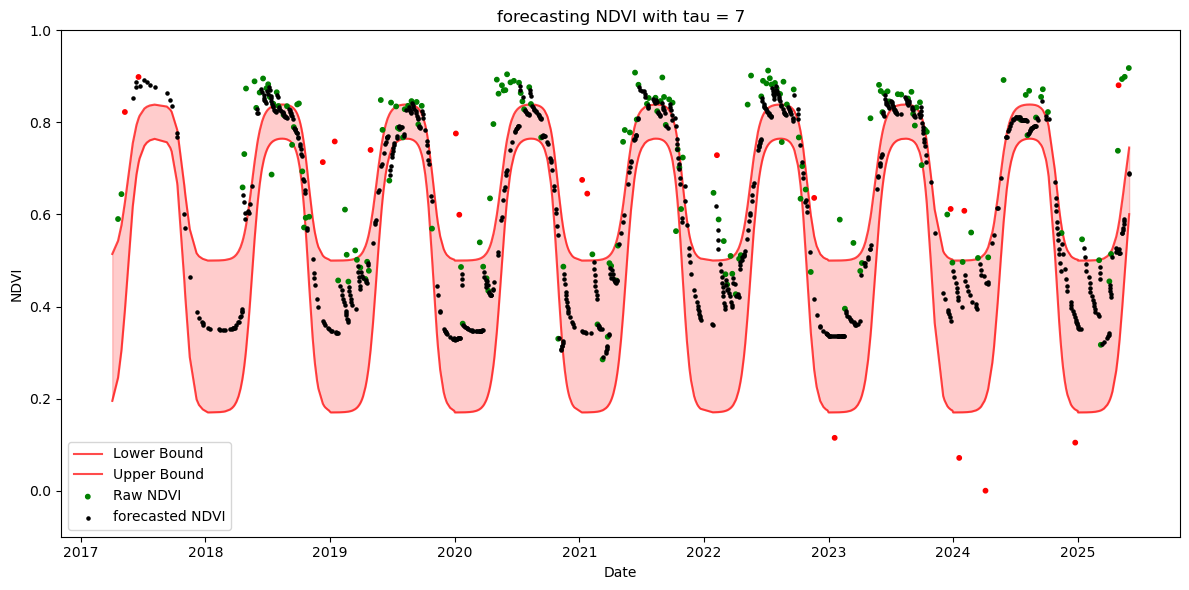

In [11]:
colors = np.where(outlier_arr, "red", "green")

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(dates_sorted, lower, label="Lower Bound", color="red", alpha=0.7)
ax.plot(dates_sorted, upper, label="Upper Bound", color="red", alpha=0.7)
ax.fill_between(dates_sorted, lower, upper, alpha=0.2, color="red")

ax.scatter(dates_sorted, ndvi_sorted / 10000.0, s=10, color=colors, label="Raw NDVI", zorder=3)
ax.scatter(dates_sorted, forecast_only, s=5, color="black", label="forecasted NDVI", zorder=3)



ax.set_title("forecasting NDVI with tau = 7")
ax.set_ylim(-0.1, 1.0)
ax.set_xlabel("Date")
ax.set_ylabel("NDVI")
ax.legend()
plt.tight_layout()

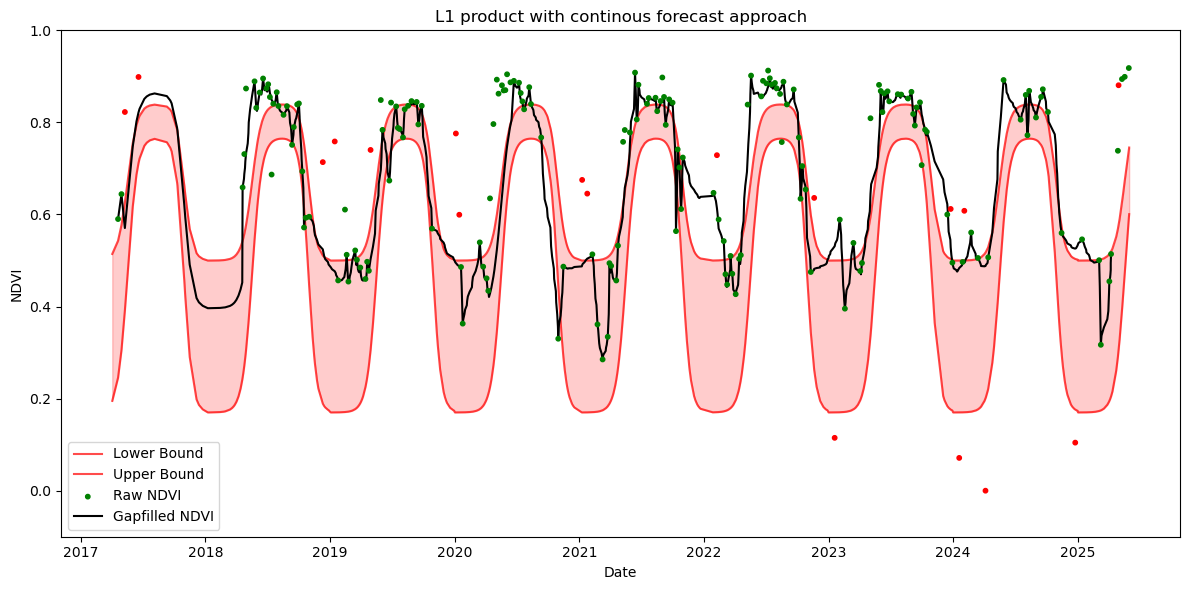

In [13]:

plot_results(
        title= "L1 product with continous forecast approach",
        ndvi_series=ndvi_sorted / 10000.0, 
        ndvi_gapfilled=ndvi_filled,
        outlier_arr=outlier_arr,
        lower=lower,
        upper=upper,
        dates=dates_sorted
    )

/home/francesco/data_scratch/swiss-ndvi-processing/demo/notebook/functions.py:114: RuntimeWarning: divide by zero encountered in divide
  iqr_param = np.where(valid_ndvi / median_valid < 1, median_valid / valid_ndvi, valid_ndvi / median_valid)
/home/francesco/data_scratch/swiss-ndvi-processing/demo/notebook/functions.py:210: RuntimeWarning: divide by zero encountered in divide
  ratio = np.maximum(valid_ndvi, median_valid) / np.minimum(valid_ndvi, median_valid)
/home/francesco/data_scratch/swiss-ndvi-processing/demo/notebook/functions.py:325: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = np.maximum(obs, median_curr) / np.minimum(obs, median_curr)


ValueError: could not broadcast input array from shape (1065,) into shape (1084,)

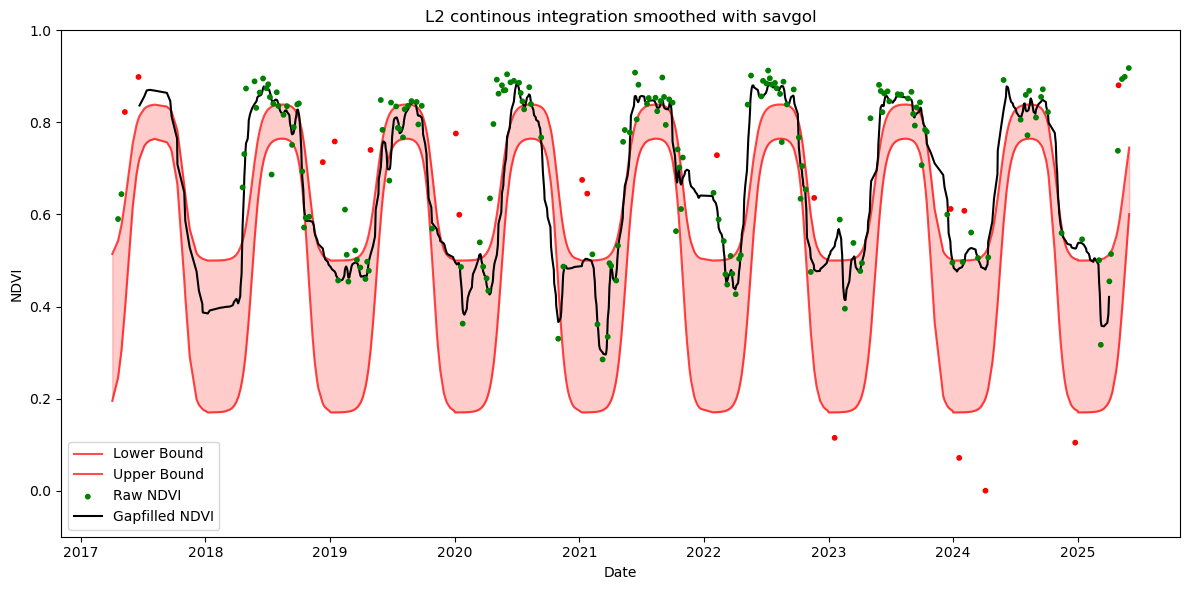

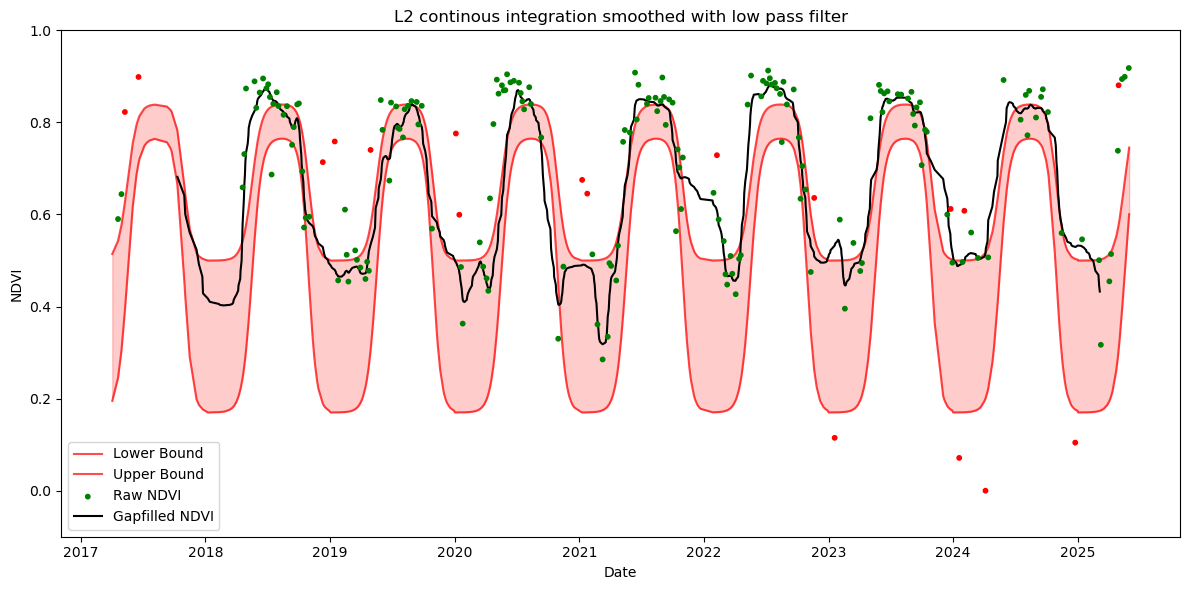

In [15]:

plot_results(
        title= "L2 continous integration smoothed with savgol",
        ndvi_series=ndvi_sorted / 10000.0, 
        ndvi_gapfilled=smoothed,
        outlier_arr=outlier_arr,
        lower=lower,
        upper=upper,
        dates=dates_sorted
    )

ndvi_filled, outlier_arr, forecast_only, smoothed = gapfill_ndvi(ndvi_sorted, lower, upper,forecasting=True,
                                                                param_iqr=1.5,
                                                                bottom_q=0.3,
                                                                top_q=0.7,
                                                                weight_median = 0.5,
                                                                y_delta_l = y_delta_l, 
                                                                y_delta_h =y_delta_h,
                                                                r_delta_h =r_delta_h, 
                                                                r_delta_l =r_delta_l, 
                                                                y_iqr = y_iqr,
                                                                r_iqr = r_iqr,
                                                                window_smoothing = 14,
                                                                smoothing_method= "low_pass",
                                                                use_tau= True,
                                                                tau = 7,
                                                                lag_forecast= 14)

plot_results(
        title= "L2 continous integration smoothed with low pass filter",
        ndvi_series=ndvi_sorted / 10000.0, 
        ndvi_gapfilled=smoothed,
        outlier_arr=outlier_arr,
        lower=lower,
        upper=upper,
        dates=dates_sorted
    )

ndvi_filled, outlier_arr, forecast_only, smoothed = gapfill_ndvi(ndvi_sorted, lower, upper,forecasting=True,
                                                                param_iqr=1.5,
                                                                bottom_q=0.3,
                                                                top_q=0.7,
                                                                weight_median = 0.5,
                                                                y_delta_l = y_delta_l, 
                                                                y_delta_h =y_delta_h,
                                                                r_delta_h =r_delta_h, 
                                                                r_delta_l =r_delta_l, 
                                                                y_iqr = y_iqr,
                                                                r_iqr = r_iqr,
                                                                window_smoothing = 14,
                                                                smoothing_method= "loess",
                                                                use_tau= True,
                                                                tau = 7,
                                                                lag_forecast= 14)

plot_results(
        title= "L2 continous integration smoothed with LOESS",
        ndvi_series=ndvi_sorted / 10000.0, 
        ndvi_gapfilled=smoothed,
        outlier_arr=outlier_arr,
        lower=lower,
        upper=upper,
        dates=dates_sorted
    )